In [4]:
import numpy as np
# Required Libraries
import pandas as pd
import random
import numpy  as np
import copy
import os
from matplotlib import pyplot as plt 
%matplotlib inline

In [5]:

def annot_plot(N, cityx, cityy):
    labels = np.arange(N)
    for label, x, y in zip(labels, cityx, cityy):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
def csp_plot(csp_x,csp_y,cityx=None, cityy=None,radius=0.1,line='-o'):        
    ax = plt.gca()
    ax.cla()
    n= len(csp_x)
    
    
    plt.plot(csp_x,csp_y,line,color='b',markersize=5,linewidth=1)
    for i in range(n):
        c = plt.Circle((csp_x[i],csp_y[i]),radius,color="orange",fill=False,linewidth=0.5)
        ax.add_artist(c)
        
    #plot covered citys
    if cityx is not None and cityy is not None:
        csp = [(csp_x[i],csp_y[i]) for i in range(len(csp_x))]
        city = [(cityx[i],cityy[i]) for i in range(len(cityx))]

        covered= np.array([[c[0],c[1]] for c in city if c not in csp])
#         print(covered)
#         print(csp)
#         print(city)
        
        plt.plot(covered[:,0],covered[:,1],'o',color='r',markersize=5,linewidth=1)
        


In [66]:
###################################################
##########  GRASP: greedy randomized adaptive search
###################################################

def cal_distance(cityx,cityy):
    N= len(cityx)
    d = np.zeros([N,N])
    # Calculate distance matrix
    for i in range(N):
        for j in range(N):
            d[i, j]=np.sqrt((cityx[i]-cityx[j])**2+(cityy[i]-cityy[j])**2)
    return d

def cal_deg_tb(d,num_city, radius=0.1):
    #calculate degree table
    degree_tb = np.zeros([num_city,num_city])
    dg_tb = np.zeros([num_city,num_city])
    for r in range(num_city):
            for c in range(num_city):
                if r!=c:
                    degree_tb[r,c] =  1 if radius- d[r,c]>=0 else 0

    return degree_tb

def cal_cluster_v2(deg_tb,cities):
    if len(cities) ==0:
        return cities
    else:
        cluster=[]
        degree = np.sum(deg_tb,axis=1)
        degs = [degree[c] for c in cities]
        city_maxdeg= [c for c in cities if degree[c]==max(degs)]
        for c_max in city_maxdeg:
            not_c_neighbors = []
            for c in cities:
                if deg_tb[c_max, c]!=1 and c_max!=c:
#                     print("c_max, c,dg:",c_max,c,deg_tb[c_max, c])
                    not_c_neighbors.append(c)
                    
#             print(not_c_neighbors)
            cities_subset = cal_cluster_v2(deg_tb,not_c_neighbors)
            if len(cities_subset)==0:
                cities_subset.append([c_max])
            else:
                s=[]
                subset_minlen = np.inf
                for c in cities_subset:
                    #select the minimum city set used for CSP
                    if len(c)<=subset_minlen:
                        subset_minlen = len(c)
                        c.append(c_max)
                        c.sort()
                        if c not in s:
                            s.append(c)
                cities_subset= s
            cluster.extend(cities_subset)
#             print(cluster)
    return cluster
def calc_CSP_Cluster(deg_tb,cities):
#     degree = np.sum(deg_tb,axis=1)
#     degs = [degree[c] for c in cities]
#     cities= [c for c in cities if degree[c]!=0]
#     other_cities= [c for c in cities if degree[c]==0]
    cluster = cal_cluster_v2(deg_tb,cities)
    
    
    
# def CSP_seed(Y,print_flag=False):
#     Y=np.array(Y)
#     d =cal_distance(Y[0],Y[1])
#     deg_tb = cal_deg_tb(d,len(d), radius=0.1)
#     print(deg_tb)
#     clusters = cal_cluster_v2(deg_tb,[i for i in range(len(d))])
#     if print_flag:
#         print("cluster:")
#     seeds = []
#     Y= Y.transpose()
    
#     for cluster in clusters:
#         print(cluster)
#         X= Y[cluster,:]
# #         print("X seed:", X)
#         Xdata= buid_distance_matrix(X)
#         seeds.append(seed_function(Xdata))
    
#     return seeds


# Function: Tour Distance
def distance_calc(Xdata, city_tour):
    distance = 0
    for k in range(0, len(city_tour[0])-1):
        m = k + 1
        distance = distance + Xdata[city_tour[0][k]-1, city_tour[0][m]-1]            
    return distance

# Function: Euclidean Distance 
def euclidean_distance(x, y):       
    distance = 0
    for j in range(0, len(x)):
        distance = (x[j] - y[j])**2 + distance   
    return distance**(1/2) 

# Function: Initial Seed
def seed_function(Xdata):
    seed = [[],float("inf")]
    sequence = random.sample(list(range(1,Xdata.shape[0]+1)), Xdata.shape[0])
    sequence.append(sequence[0])
    seed[0] = sequence
    seed[1] = distance_calc(Xdata, seed)
    return seed



def CSP_seed(Y,print_flag=False,radius=0.1):
    Y=np.array(Y)
    d =cal_distance(Y[0],Y[1])
    deg_tb = cal_deg_tb(d,len(d), radius=radius)
    if print_flag:
        print(deg_tb)
    clusters = cal_cluster_v2(deg_tb,[i for i in range(len(d))])

    seeds = []
    Xdatas= []
    tours = []
    Y= Y.transpose()
    if print_flag:
        print("cluster:")    
    for cluster in clusters:
        if print_flag:
            print(np.array(cluster))
        X= Y[cluster,:]
        tours.append(X)
#         print("X seed:", X)
        Xdata= buid_distance_matrix(X)
        Xdatas.append(Xdata)
        seeds.append(seed_function(Xdata))
    
    return seeds,Xdatas,tours

# Function: Build Distance Matrix
def buid_distance_matrix(coordinates):
    Xdata = np.zeros((coordinates.shape[0], coordinates.shape[0]))
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            if (i != j):
                x = coordinates[i,:]
                y = coordinates[j,:]
                Xdata[i,j] = euclidean_distance(x, y)        
    return Xdata

# Function: Tour Plot
def plot_tour_distance_matrix (Xdata, city_tour):
    m = np.copy(Xdata)
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            m[i,j] = (1/2)*(Xdata[0,j]**2 + Xdata[i,0]**2 - Xdata[i,j]**2)    
    w, u = np.linalg.eig(np.matmul(m.T, m))
    s = (np.diag(np.sort(w)[::-1]))**(1/2) 
    coordinates = np.matmul(u, s**(1/2))
    coordinates = coordinates.real[:,0:2]
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Tour Plot
def plot_tour_coordinates (coordinates, city_tour):
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Rank Cities by Distance
def ranking(Xdata, city = 0):
    rank = np.zeros((Xdata.shape[0], 2)) # ['Distance', 'City']
    for i in range(0, rank.shape[0]):
        rank[i,0] = Xdata[i,city]
        rank[i,1] = i + 1
    rank = rank[rank[:,0].argsort()]
    return rank

# Function: RCL
def restricted_candidate_list(Xdata, greediness_value = 0.5):
    seed = [[],float("inf")]
    sequence = []
    sequence.append(random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0])
    count = 1
    for i in range(0, Xdata.shape[0]):
        count = 1
        rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        if (rand > greediness_value and len(sequence) < Xdata.shape[0]):
            next_city = int(ranking(Xdata, city = sequence[-1] - 1)[count,1])
            while next_city in sequence:
                count = np.clip(count+1,1,Xdata.shape[0]-1)
                next_city = int(ranking(Xdata, city = sequence[-1] - 1)[count,1])
            sequence.append(next_city)
        elif (rand <= greediness_value and len(sequence) < Xdata.shape[0]):
            next_city = random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0]
            while next_city in sequence:
                next_city = int(random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0])
            sequence.append(next_city)
    sequence.append(sequence[0])
    seed[0] = sequence
    seed[1] = distance_calc(Xdata, seed)
    return seed

# Function: 2_opt
def local_search_2_opt(Xdata, city_tour):
    tour = copy.deepcopy(city_tour)
    best_route = copy.deepcopy(tour)
    seed = copy.deepcopy(tour)  
    for i in range(0, len(tour[0]) - 2):
        for j in range(i+1, len(tour[0]) - 1):
            best_route[0][i:j+1] = list(reversed(best_route[0][i:j+1]))           
            best_route[0][-1]  = best_route[0][0]                          
            best_route[1] = distance_calc(Xdata, best_route)           
            if (best_route[1] < tour[1]):
                tour[1] = copy.deepcopy(best_route[1])
                for n in range(0, len(tour[0])): 
                    tour[0][n] = best_route[0][n]          
            best_route = copy.deepcopy(seed) 
    return tour

def greedy_randomized_adaptive_search_procedure(Xdatas,distances, city_tours,print_flag=False, iterations = 50, rcl = 25, greediness_value = 0.5):
    
    csp_optimal_tour = copy.deepcopy(city_tours[0])
    Xposition= Xdatas[0]
    optimal_dist = distances[0]
    cost_ls = []
     
    for ind, city_tour in enumerate(city_tours):        
        count = 0
        Xdata =Xdatas[ind].copy()
        dist = distances[ind]
        best_solution = copy.deepcopy(city_tour)
        while (count < iterations):
            rcl_list = []
            for i in range(0, rcl):
                rcl_list.append(restricted_candidate_list(Xdata, greediness_value = greediness_value))
            candidate = int(random.sample(list(range(0,rcl)), 1)[0])
            city_tour = local_search_2_opt(Xdata, city_tour = rcl_list[candidate])
    #         update until tour no change
            while (city_tour[0] != rcl_list[candidate][0]):
                rcl_list[candidate] = copy.deepcopy(city_tour)
                city_tour = local_search_2_opt(Xdata, city_tour = rcl_list[candidate])
            if (city_tour[1] < best_solution[1]):
                best_solution = copy.deepcopy(city_tour) 
            count = count + 1
            
            if print_flag:
                print("Iteration =", count, "-> Distance =", best_solution[1])
        cost_ls.append(best_solution[1])
        if (csp_optimal_tour[1] > best_solution[1]):
                csp_optimal_tour = copy.deepcopy(best_solution) 
                Xposition = Xdata.copy()
                optimal_dist = dist
        if print_flag:
            print("Csp tour distance =",csp_optimal_tour[1])
    print("csp_optimal_tour=", csp_optimal_tour)
    return csp_optimal_tour,Xposition, optimal_dist, cost_ls


Y = [[0.8288664580792412, 0.7658800900588833, 0.7603239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.4459026808967777, 0.8617379522531833, 0.9095975954158632, 0.4372837155846553, 0.5598494558486277, 0.6344199646245794, 0.2865151077809903],
[0.38985101740345411, 0.4432406013058108, 0.4258587496695838, 0.19641246752077235, 0.3942326051727322, 0.1856299208476521, 0.8781026397358788, 0.7619632229248947, 0.5929195371832988, 0.8431010233573926, 0.1807997001072792, 0.2727695693633255, 0.20137275527808297]]


def grasp(data_set, print_flag=False,radius=0.1):
    lsgrasp_ls =[]
    optimal_dist_ls = []
    cost_set = []
    for Y in data_set:
        Y_tp= np.array(Y).transpose()
        # Build the Distance Matrix
        X = buid_distance_matrix(Y_tp)
        # Start a Random Seed
        seeds,Xdatas, distancedata = CSP_seed(Y,radius=radius)
        lsgrasp,Xposition,optimal_dist, cost_ls = greedy_randomized_adaptive_search_procedure(Xdatas,  print_flag=print_flag,distances= distancedata, city_tours =seeds, iterations = 10, rcl = 15, greediness_value = 0.5)
        lsgrasp_ls.append(lsgrasp)
        optimal_dist_ls.append(optimal_dist)
        cost_set.append(cost_ls)
    return lsgrasp_ls,optimal_dist_ls,cost_set



lsgrasp_ls,optimal_dist_ls,cost_set = grasp([Y])

csp_optimal_tour= [[1, 4, 3, 5, 2, 6, 7, 1], 2.0412300721463192]


Worst cost: 2.1909209043433213 , average cost: 2.109432613122596  best cost: 2.0412300721463192


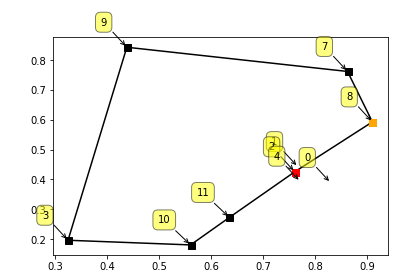

In [67]:
lsgrasp = lsgrasp_ls[0]
optimal_dist = optimal_dist_ls[0]
cost_ls = cost_set[0]
plot_tour_coordinates(optimal_dist, lsgrasp)
annot_plot(len(Y_tp),Y_tp[:,0],Y_tp[:,1])
print("Worst cost:", max(cost_ls),", average cost:", np.mean(cost_ls)," best cost:",min(cost_ls))


In [68]:

#########################################
# local search 2 for CSP
#########################################



# Function: Tour Distance
def distance_calc(Xdata, city_tour):
    distance = 0
    for k in range(0, len(city_tour[0])-1):
        m = k + 1
        distance = distance + Xdata[city_tour[0][k]-1, city_tour[0][m]-1]            
    return distance

# Function: Euclidean Distance 
def euclidean_distance(x, y):       
    distance = 0
    for j in range(0, len(x)):
        distance = (x[j] - y[j])**2 + distance   
    return distance**(1/2) 

# Function: Initial Seed
def seed_function(Xdata):
    seed = [[],float("inf")]
    sequence = random.sample(list(range(1,Xdata.shape[0]+1)), Xdata.shape[0])
    sequence.append(sequence[0])
    seed[0] = sequence
    seed[1] = distance_calc(Xdata, seed)
    return seed

# Function: Build Distance Matrix
def buid_distance_matrix(coordinates):
    Xdata = np.zeros((coordinates.shape[0], coordinates.shape[0]))
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            if (i != j):
                x = coordinates[i,:]
                y = coordinates[j,:]
                Xdata[i,j] = euclidean_distance(x, y)        
    return Xdata

# Function: Tour Plot
def plot_tour_distance_matrix (Xdata, city_tour):
    m = np.copy(Xdata)
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            m[i,j] = (1/2)*(Xdata[0,j]**2 + Xdata[i,0]**2 - Xdata[i,j]**2)    
    w, u = np.linalg.eig(np.matmul(m.T, m))
    s = (np.diag(np.sort(w)[::-1]))**(1/2) 
    coordinates = np.matmul(u, s**(1/2))
    coordinates = coordinates.real[:,0:2]
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Tour Plot
def plot_tour_coordinates (coordinates, city_tour):
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Rank Cities by Distance
def ranking(Xdata, city = 0):
    rank = np.zeros((Xdata.shape[0], 2)) # ['Distance', 'City']
    for i in range(0, rank.shape[0]):
        rank[i,0] = Xdata[i,city]
        rank[i,1] = i + 1
    rank = rank[rank[:,0].argsort()]
    return rank

# Function: RCL
def restricted_candidate_list(Xdata, greediness_value = 0.5):
    seed = [[],float("inf")]
    sequence = []
    sequence.append(random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0])
    count = 1
    for i in range(0, Xdata.shape[0]):
        count = 1
        rand = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        if (rand > greediness_value and len(sequence) < Xdata.shape[0]):
            next_city = int(ranking(Xdata, city = sequence[-1] - 1)[count,1])
            while next_city in sequence:
                count = np.clip(count+1,1,Xdata.shape[0]-1)
                next_city = int(ranking(Xdata, city = sequence[-1] - 1)[count,1])
            sequence.append(next_city)
        elif (rand <= greediness_value and len(sequence) < Xdata.shape[0]):
            next_city = random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0]
            while next_city in sequence:
                next_city = int(random.sample(list(range(1,Xdata.shape[0]+1)), 1)[0])
            sequence.append(next_city)
    sequence.append(sequence[0])
    seed[0] = sequence
    seed[1] = distance_calc(Xdata, seed)
    return seed

# Function: 2_opt
def local_search_2_opt(Xdata, city_tour):
    tour = copy.deepcopy(city_tour)
    best_route = copy.deepcopy(tour)
    seed = copy.deepcopy(tour)  
    for i in range(0, len(tour[0]) - 2):
        for j in range(i+1, len(tour[0]) - 1):
            best_route[0][i:j+1] = list(reversed(best_route[0][i:j+1]))           
            best_route[0][-1]  = best_route[0][0]                          
            best_route[1] = distance_calc(Xdata, best_route)           
            if (best_route[1] < tour[1]):
                tour[1] = copy.deepcopy(best_route[1])
                for n in range(0, len(tour[0])): 
                    tour[0][n] = best_route[0][n]          
            best_route = copy.deepcopy(seed) 
    return tour


def build_covermatrix(dis_matrix ,radius=0):
    n = len(dis_matrix)
    cover_matrix = np.zeros(dis_matrix.shape)
    for i in range(n):
        for j in range(n):
            if dis_matrix[i,j]<= radius:
                cover_matrix[i,j] = 1
    return cover_matrix
        

def check_solution(city_tour,tot_cities, cover_matrix):
    #tot_cities： the set containing all city's index
    #city_tour: the tour to be improved
    #cover_matrix: binary matrix indicating if city is covered
    is_valid= True
    tour  = city_tour[0].copy()
    tour.pop()
    tour_indices=np.array(tour)-1
    city_outside = [c for c in tot_cities if c not in tour]
    
    
    for c_j in city_outside:
            if sum(cover_matrix[tour_indices,c_j-1])==0:
                is_valid = False
    if len(tour)+len(city_outside)!=len(tot_cities):
        is_valid = False
#     print("Tour City:",city_tour, "outside:",city_outside,"Valid:",is_valid)
    return is_valid
            
    
def improvement_procedure(city_s, tot_cities, Xdata, cover_matrix,T=3):
    # city_s:  tour to be updated, with structure (tour, cost)
    #tot_cities: a list of all city's indices
    #Xdata: distance matrix
    #cover_matrix: binary covering matrix
    
    n= len(city_s[0])-1
    improve_flag= False
    r = 1
    improved_city= copy.deepcopy(city_s)
    
    #loop through all cities on tour
    city_list = city_s[0].copy()
    #Note: the head and the end are the same city in tour
    city_list.pop(0)
    
    while r<=n:
#         print("r=",r)
        r += 1
        #select r_th node
#         r_node = city_list.pop(random.randint(0,len(city_list)-1))
        r_node = city_list[0]
        city_list.pop(0)
        #index of r^th node in original tour city_s
        r_node_index = city_s[0].index(r_node)
        new_tour = copy.deepcopy(city_s)
        if r_node != city_s[0][0]:
            new_tour[0].pop(r_node_index)
            new_tour[1] = distance_calc(Xdata, new_tour)
        else:
            new_tour[0].pop(0)
            new_tour[0][-1] = new_tour[0][0]
            new_tour[1] = distance_calc(Xdata, new_tour)
        #check if updated tour is feasible
        if check_solution(new_tour,tot_cities, cover_matrix):
            improve_flag =True
            improved_city = copy.deepcopy(new_tour)
#             print("Obtained CSP sol:", improved_city)
#             break
        else:
            #if solution is infeasible after removing the node
            #select the T closest node
            subseq = [(Xdata[r_node-1,i-1],i) for i in tot_cities if i not in city_s]
            subseq.sort()
            
            #compute insertion cost
            city_seq = [node[1] for node in subseq]
            replaced_cities = copy.deepcopy(city_s)
            insertion_cost = 0.0
            new_node= r_node
            cnt =0
            for node in city_seq:
                replaced_cities[0][r_node_index]= node
                if  r_node == city_s[0][0]:
                    replaced_cities[0][-1]= replaced_cities[0][0]
                    
                replaced_cities[1]=distance_calc(Xdata, replaced_cities)
                cost = replaced_cities[1] - city_s[1]
                if cost < insertion_cost and check_solution(replaced_cities,tot_cities, cover_matrix):
                    new_node = node
                    insertion_cost = cost
                    cnt+=1
                if cnt>=T:
                    break
#             print("Node with minimum insertion cost:", new_node, insertion_cost)
            if insertion_cost<= 0.0:
                improved_city = copy.deepcopy(city_s)
                improved_city[0][r_node_index] = new_node
                if  r_node == city_s[0][0]:
                    improved_city[0][-1] = improved_city[0][0]
                improved_city[1] = distance_calc(Xdata, improved_city)
                improve_flag = True
#                 break
        
    return improve_flag, improved_city 


def perturbation_procedure(city_s, tot_cities, Xdata, cover_matrix,k=1):
        #city_s: the valid tour solution
        
        if k<1:
            print("Warn: Perturbation procedure: K must be >0.")
            return None
        cities_outside = [c for c in tot_cities if c not in city_s]
        all_cities=  copy.deepcopy(tot_cities)
#         all_cities=  copy.deepcopy(city_s[0])
        new_solution= copy.deepcopy(city_s)
        for i in range(k):
            new_node = random.sample(all_cities,1)[0]
            all_cities.pop(all_cities.index(new_node))
            
            buffer = copy.deepcopy(city_s)
            buffer[0].pop()
            num_insertion = len(city_s)-1
            best_cost= float("Inf")
            for i in range(num_insertion):
                if new_node  in buffer[0]:
                    buffer[0].pop(buffer[0].index(new_node))
                    
                buffer[0].insert(i,new_node)
                buffer[0].append(buffer[0][0])
                buffer[1]= distance_calc(Xdata, buffer)
                if buffer[1]<best_cost:
                        best_cost= buffer[1]
                        new_solution = copy.deepcopy(buffer)
                buffer[0].pop()
                buffer[0].pop(i)
            
        return new_solution
            
            
        

def Local_Search2(Xdata, city_tour,num_cities, cover_matrix, print_flag=False,T=5, iterations = 20, J = 10):
    tot_cities=[i for i in range(1,num_cities+1)]
    best_solution = copy.deepcopy(city_tour)
    cost_ls=[]
    cost_ls.append(city_tour[1])
    for count in range(iterations):
        best_improved= False
        for j in range(J):
            improve_flag = False
            while  not improve_flag:
                improve_flag, city_tour=  improvement_procedure(city_tour,tot_cities , Xdata, cover_matrix,T=8)
       
            city_tour = local_search_2_opt(Xdata, city_tour = city_tour)

            if city_tour[1]<best_solution[1]:
                best_solution = copy.deepcopy(city_tour)
                best_cost= city_tour[1]
                best_improved = True
            else:
                city_tour = copy.deepcopy(best_solution)
            
            city_tour = perturbation_procedure(city_tour, tot_cities, Xdata, cover_matrix,k=len(city_tour[0])-1)
        cost_ls.append(city_tour[1])
        if best_improved:
            #obtain TSP solution
            city_tour = local_search_2_opt(Xdata, city_tour = city_tour)
            best_solution = copy.deepcopy(city_tour) 
        if print_flag:
            print("Iteration =", count, "-> Distance =", best_solution[1])
#     solution= [i-1 for i in best_solution[0] ]
    print("Best Solution =", best_solution)
    return best_solution, cost_ls

######################## Part 1 - Usage ####################################

# # Load File - A Distance Matrix (17 cities,  optimal = 1922.33)
# X = pd.read_csv('Python-MH-Local Search-GRASP-Dataset-01.txt', sep = '\t') 
# X = X.values
# X= X/2000.0
# print(X)
# # Start a Random Seed
# seed = seed_function(X)

# # Call the Function
# lsgrasp = greedy_randomized_adaptive_search_procedure(X, city_tour = seed, iterations = 5, rcl = 5, greediness_value = 0.5)

# # Plot Solution. Red Point = Initial city; Orange Point = Second City # The generated coordinates (2D projection) are aproximated, depending on the data, the optimum tour may present crosses
# plot_tour_distance_matrix(X, lsgrasp)

######################## Part 2 - Usage ####################################

# Load File - Coordinates (Berlin 52,  optimal = 7544.37)
# Y = pd.read_csv('Python-MH-Local Search-GRASP-Dataset-02.txt', sep = '\t') 
# Y = Y.values

Y = [[0.8288664580792412, 0.7658800900588833, 0.7603239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.4459026808967777, 0.8617379522531833, 0.9095975954158632, 0.4372837155846553, 0.5598494558486277, 0.6344199646245794, 0.2865151077809903],
[0.38985101740345411, 0.4432406013058108, 0.4258587496695838, 0.19641246752077235, 0.3942326051727322, 0.1856299208476521, 0.8781026397358788, 0.7619632229248947, 0.5929195371832988, 0.8431010233573926, 0.1807997001072792, 0.2727695693633255, 0.20137275527808297]]

def LS2(data_set,print_flag=False,radius=0.1):
    cost_set = []
    ls2_list= []
    for Y in data_set:
        Y_tp= np.array(Y).transpose()
        # Y = np.random.random([50,2])
#         print(Y_tp)
        # Build the Distance Matrix
        Xdata = buid_distance_matrix(Y_tp)
        cover_matrix = build_covermatrix(Xdata ,radius=radius)
        # Start a Random tour
        seed = seed_function(Xdata)
#         print("Seed:",seed[0])
        # Call the Function
        lsgrasp ,cost_ls= Local_Search2(Xdata, seed,len(Y_tp), cover_matrix, print_flag=print_flag,iterations = 50,J=20)
        cost_set.append(cost_ls)
        ls2_list.append(lsgrasp)
    return ls2_list , cost_set 

ls2_list , cost_set  = LS2([Y])
lsgrasp= ls2_list[0]
cost_ls= cost_set[0]

Best Solution = [[3, 9, 8, 10, 4, 11, 12, 3], 2.0412300721463192]


Worst cost: 5.85976171244006 , average cost: 2.51845024867577  best cost: 2.0412300721463192


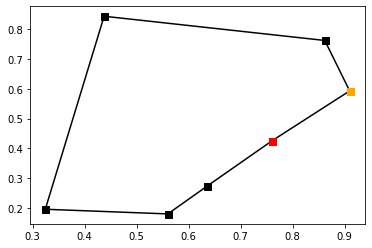

In [69]:
# Plot Solution. Red Point = Initial city; Orange Point = Second City
plot_tour_coordinates(np.array(Y).transpose(), lsgrasp)
print("Worst cost:", max(cost_ls),", average cost:", np.mean(cost_ls)," best cost:",min(cost_ls))

In [70]:
################################################
########  Hopfield for GSP
###############################################


def total_distance_csp(p,cx,cy):
    cityx_final=[]
    cityy_final=[]
    for i in range(np.shape(p)[0]):
        if max(p[:,i])==1:
            ind =np.argmax(p[:,i])
            cityx_final.append(cx[ind])
            cityy_final.append(cy[ind])
    cityx_final.append(cityx_final[0])
    cityy_final.append(cityy_final[0])
        
    td=0.0
    for j in range(len(cityx_final)):
        if j>0:
            i=j-1
        else:
            i=len(cityx_final)-1
        d = (cityx_final[j]-cityx_final[i])**2
        d +=(cityy_final[j]-cityy_final[i])**2
        d = np.sqrt(d)
        td+=d
        
    return(td, cityx_final, cityy_final)





def k_delta(i,j):
        return 1.0 if i==j else 0.0

def step(x, threshold=0.0):
    return 1 if x>=threshold else 0

def cal_num_cluster(dg_tb):
    if len(dg_tb)==0:
        return 0
    else:
        depth_ls =[]
        deg = np.sum(dg_tb, axis=1).tolist()
        dg_max= max(deg)
        if dg_max!=0:
            indices = [i for i in range(len(deg)) if deg[i]==dg_max]
        else:
            indices = [0]
        for ind in indices:
            rows = [ind]
            if dg_max!=0:
                rows.extend([i for i in range(len(dg_tb)) if dg_tb[ind,i]==1])
            
            temp = np.delete(dg_tb, rows,0)
            temp = np.delete(temp, rows,1)    
            depth_ls.append(cal_num_cluster(temp))
        min_depth= min(depth_ls)
        min_depth+=1
        
        m= min_depth
    return m



class Hopfield():
    def __init__(self,d,cityx,cityy,num_city=10, coeff=None,radius=0.1,print_flag= False):
        if coeff != None:
                self.A,self.B,self.C,self.D,self.F= coeff[0],coeff[1],coeff[2],coeff[3],coeff[4]
        else:
            # initialize coefficient
            self.A =10.0
            self.B =10.0
            self.C =10.0
            self.D =5.0
            self.F =0.0
        #radius of covering region
        self.radius = radius
        #distance table
        self.d = d
        
        self.cityx=cityx
        self.cityy= cityy
        #flatten output table into a single column vector
        #There are num_city+1 columns in my modified Hpfield network in covering salesman problem
        self.num_city = num_city
        self.num_step = num_city
        self.o_shape = num_city**2
        #calculate degree table
        self.degree_tb = np.zeros([self.num_city,self.num_city])
        dg_tb = np.zeros([self.num_city,self.num_city])
        for r in range(self.num_city):
            for c in range(self.num_city):
                if r!=c:
                    self.degree_tb[r,c] = step(self.radius- d[r,c])
#                     if r<c:
#                         dg_tb[r,c]= step(self.radius- d[r,c])
#         print("degree tb:")
#         print(self.degree_tb)
        
        #calculate the number of clusters of cities
        m= cal_num_cluster(self.degree_tb)    
        if print_flag:
            print("m:",m)
        self.m=m
        #calculate weights
        self.cal_weights(self.A,self.B,self.C,self.D,self.F)
        pass
    
    
    def cal_weights(self,A,B,C,D,F):
        """
        weights obtained from w = -d^2E/do2
        """
        num_c = self.num_city
        self.w= np.zeros([self.o_shape,self.o_shape])
        for x in range(self.num_city):
            for y in range(self.num_city):
                for i in range(self.num_step):
                    for j in range(self.num_step):
                        self.w[x*self.num_city + i, y*self.num_city + j]-= (A*k_delta(x,y)*(1-k_delta(i,j)))
                        self.w[x*self.num_city + i, y*self.num_city + j]-= (B*k_delta(i,j)*(1-k_delta(x,y))  )
                        self.w[x*self.num_city + i, y*self.num_city + j]-= C
                        self.w[x*self.num_city + i, y*self.num_city + j]-= (D*self.d[x,y]*(k_delta(i+1 if i<num_c-1 else 0,j)
                                                                                + k_delta(i-1 if i>0 else num_c-1,j)))

                        k = 0.0
                        for z in range(self.num_city):
                            k += step(self.radius - self.d[x,z])*step(self.radius - self.d[z,y])
                        self.w[x*self.num_city + i, y*self.num_city + j]-=(k*F)
        
        return self.w
    
    def cal_net(self,A,B,C,D,F,o):
        """
        first order net = -dE/do
        """
        o= o.reshape([self.num_city,self.num_step])
        net = o.copy()
        for x in range(self.num_city):
            for i in range(self.num_step):
                x1,x2,x3,x4,x5=0.0,0.0,0.0,0.0,0.0
                
                for j in range(self.num_step):
                    if j != i:
                        x1 += o[x,j]
                        
                for y in range(self.num_city):
                    if y != x:
                        x2 += o[y,i]
                
         
                x3= np.sum(o)- self.m

                for y in range(self.num_city):
                        if y!=x :
                            if i==0:
                                x4+=self.d[x, y]*(o[y, i+1]+o[y, self.num_city-1])
                            elif i==self.num_city-1:
                                x4+=self.d[x, y]*(o[y, i-1]+o[y, 0])
                            else:
                                x4+=self.d[x, y]*(o[y, i+1]+o[y, i-1])                            
                
                
         
                # using Err = (sum(o[x,:])+sum(o[y,:])-1)^2   when y!=x and y is covered by x
                
                x5 =0.0
                for z in range(self.num_city):
                    x_t=0.0
                    for y in range(self.num_city):
                                x_t += np.sum(o[y,:])*step(self.radius - self.d[z,y])
                    
                    x_t -=1.0
                    x_t *= step(self.radius - self.d[x,z])
                    #x_t *=2.0
                    x5+=x_t
                
             
                
                net[x,i] =-A*x1-B*x2-C*x3-D*x4 -F*x5
                
        net = net.reshape([self.o_shape,])
        return net
    
    
    def cal_E(self,o):
        E, E1,E2,E3,E4,E5= 0.0, 0.0,0.0,0.0,0.0,0.0
        o_n= o.reshape([self.num_city,self.num_step])
        
        num_c=self.num_city
        #E1
        E1= 0.0
        for x in range(self.num_city):
            for i in range(self.num_step):
                for j in range(self.num_step):
                    if i!=j:
                        E1 += o[x*self.num_city +i]*o[x*self.num_city +j]
        E1 *= self.A*0.5
        
        #E2
        E2=0.0
        for i in range(self.num_step):
            for x in range(self.num_city):
                for y in range(self.num_city):
                    if x!=y:
                        E2 += o[x*self.num_city +i]*o[y*self.num_city +i]
        E2 *=self.B*0.5
        
        
        #E3   
        E3 = (np.sum(o) - self.m)**2
        E3 = E3*self.C*0.5
        
        #E4
        E4=0.0
        for i in range(self.num_step):
            for x in range(self.num_city):
                for y in range(self.num_city):
                    if x!=y:
                        k1 =i+1 if i<num_c-1 else 0
                        k2 =i-1 if i>0 else num_c-1
                        E4 += self.d[x,y]*o[x*self.num_city +i]*(o[y*self.num_city +k1]
                                                                                    + o[y*self.num_city +k2])
        E4 *=self.D*0.5
        
        #E5
        E5=0.0
        o= o.reshape([self.num_city,self.num_step])
        for x in range(self.num_city):
            s_oy= 0.0
            s_ox= np.sum(o[x,:])
            for y in range(self.num_city):
                if step(self.radius - self.d[x,y]) ==1.0 and x!=y:
                        s_oy += np.sum(o[y,:])
            E5+= (s_oy+s_ox-1)**2
        E5=0.5*self.F*E5   
                    
        
       
        E = E1+E2+E3+E4+E5
        
        return E,E1,E2,E3,E4,E5
    
    def train(self,oi=None, max_itr=30, hot=0,alpha=0.00005,ep=1000,sample=0,net0=None,print_flag=False,debug=False,method=1,th=0.7,G=0.0):
       
        t = 1.0
        u0=0.02
        itr =0
        p = []
        err=[]
        o_init=[]
        dis=[]
        o_init_min=None
        Err= []
         #initialize  net0, o0, previous minimum distance d_prev 
        if net0 is None:
            net0 = np.ones(self.o_shape)*(-u0*np.log(self.num_city-1)/2)
            net0= np.zeros(self.o_shape)
        if oi is not None:
                max_itr =1  
        
        #generate samples
        if sample:
                    samples=[]
                    for _ in range(max_itr):
                        sp= np.random.randint(0,2,[self.num_city*self.num_step,])
                        samples.append(sp)
        else:
                    samples=[]
                    for _ in range(max_itr):
                        n=self.num_city
                        sp= np.zeros([self.num_city,self.num_step])
                        l= [i for i in range(self.num_step)]
                        for i in range(self.num_city):
                            ind= np.random.choice(l)
                            sp[i,ind]=1
                            l.remove(ind)
                        sp=sp.reshape([self.num_city*self.num_step,])
                        samples.append(sp)
        
        while itr<max_itr:
             
            #select method to generate initial pattern
            if max_itr>1:
                o_i = samples[itr].copy()
            else:
                o_i = oi.copy()
                
            o=o_i.copy()
            net = net0.copy()
            d_prev= np.inf
            mini_path = None
            
            itr += 1
            #iterate from different initial output o
            for j in range(ep):             
                s_o = o.reshape([self.num_city,self.num_city])
                bias = np.ones([self.num_city,])
                for x in range(self.num_city):
                    b =0.0
                    for z in range(self.num_city):
                        b+= step(self.radius - self.d[x,z])
                    bias[x] =b
                bias =bias.reshape([self.num_city,1])
                bias_F = self.F*(bias*np.ones([self.num_city,self.num_city])).reshape(o.shape)
                
                #first order derivative
                h_net = np.dot(self.w,o) + self.C*self.m +bias_F

                #updata net
                d_net = -net+ h_net
                net += d_net*alpha
                if j%10==0 and debug:
                    print("Net")
                    print(h_net)
                #activation
                o_new = 0.5*(1+np.tanh(net/u0))
                #threshold
                for i in range(len(o_new)):
                    o_new[i]= 1.0 if o_new[i]>=th else  0.0
                o = o_new 

                      
                if j%100==0:
                    #compute cost
                    c= self.cal_E(o)
                    E,E1,E2,E3,E4,E5 = c
                    Err.append(E)
                if j%200 == 0 and debug:
                    print("At run {} with Cost {}".format(itr,c))
                #validate new output
                paths = np.reshape(o,[self.num_city, self.num_step])
                if j%10==0 and debug:
                    print("paths:")
                    print(paths)
                
                flag = True
                for x in range(self.num_city):
                    f1,f2,f3,f4=0.0,0.0,0.0,0.0
                    #check row
                    f1=np.sum(paths[x,:])
                    #check column
                    f2= np.sum(paths[:,x])
                    # exact number of 1 = number of city
                    f3= np.sum(paths)
                    f4 = 0.0
                    s_oy= 0.0
                    s_ox= np.sum(paths[x,:])
                    for y in range(self.num_city):
                        if step(self.radius - self.d[x,y]) ==1.0 and x!=y:
                                s_oy += np.sum(paths[y,:])
                    f4+= (s_oy+s_ox-1)**2
                    f4=0.5*self.F*f4   
                        
                    if f1>1 or f2>1 or f3!=self.m or f4!=0:
                        flag =False
                        break
                        

                if flag:
                    d,_,_= total_distance_csp(paths,self.cityx,self.cityy)
                    if d<d_prev and d!=0.0:
                        #update minimum path and minimum distance in a trajectory
#                         print("------->Valid path with Distance: {}, cost:{}".format(d,c))
#                         print(paths)
                        d_prev=d
                        #update minimun path in the trajectory
                        mini_path = paths.copy()                
            
            
            #add minimum distance and path of a trajectory
            if mini_path is not None:
                #add obtained minimum path to solution list
                p.append(mini_path)
                #add corresponding path distance to list
                dis.append(d_prev)
                #store error trajectory
                err.append(Err)
                #add valid init pattern o to list
                o_init.append(o_i)
                
                
            if len(p)>0:
                #check the optimal solution already found in the previous trajectories 
                ind = np.argmin(dis)
                if print_flag:
                    if itr%10==0:
                        print("After {} runs".format(itr))
                        print("Found min path with distance {}:".format(dis[ind]))
#                 print(p[ind])
                o_init_min = o_init[ind]
            #clear Err buffer
            Err=[]    
        ind = np.argmin(dis)
        print("====> Found optimal path with distance {}:".format(dis[ind]))
        print(p[ind])
        
        return err, p,o_init, dis
    

In [137]:
data = [[0.8288664580792412, 0.7658800900588833, 0.7603239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.4459026808967777, 0.8617379522531833, 0.9095975954158632, 0.4372837155846553, 0.5598494558486277, 0.6344199646245794, 0.2865151077809903],
[0.38985101740345411, 0.4432406013058108, 0.4258587496695838, 0.19641246752077235, 0.3942326051727322, 0.1856299208476521, 0.8781026397358788, 0.7619632229248947, 0.5929195371832988, 0.8431010233573926, 0.1807997001072792, 0.2727695693633255, 0.20137275527808297]]
# l= np.random.random([2,M1])

def HNN(data_set,print_flag=False,radius=0.1):
    cost_set = []
    position = []
    for data in data_set:
        data= np.array(data)
        cityx_m1 = data[0,:]
        cityy_m1 = data[1,:]
        M1= len(cityx_m1)
        d_m1 = cal_distance(cityx_m1,cityy_m1)

        m1 =Hopfield(d_m1,cityx_m1,cityy_m1,print_flag=print_flag,num_city=M1,coeff=[50,50,100,65,100], radius=radius)
        E_m1,p_m1,o_init_m1,dis_m1=m1.train()
        ind_m1= np.argmin(dis_m1)
        #solution generated by Hopfield
        optimal_p_m1=p_m1[ind_m1]
        oi_m1 = o_init_m1[ind_m1]
        td_m1,x_m1,y_m1=total_distance_csp(optimal_p_m1,cityx_m1,cityy_m1)
        position.append((x_m1,y_m1,td_m1))
        cost_set.append(dis_m1)
    return position,cost_set


# position,cost_set = HNN([data],print_flag=True)
# x_m1,y_m1,td_m1 = position[0]
# cityx_m1, cityy_m1 = data[0],data[1]
# cost_ls = cost_set[0]

2.081787235395257
Worst cost: 3.217045806153641 , average cost: 2.5535844983270324  best cost: 2.0794511381599627


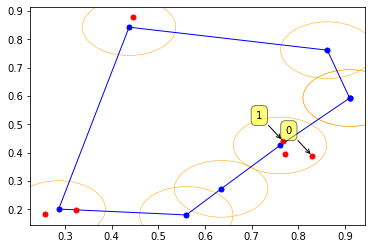

In [72]:
M1= len(data)
csp_plot(x_m1,y_m1,cityx_m1,cityy_m1)
annot_plot(M1, cityx_m1, cityy_m1)
print(td_m1)
cost_ls= dis_m1
print("Worst cost:", max(cost_ls),", average cost:", np.mean(cost_ls)," best cost:",min(cost_ls))

In [96]:

def scp_HNN(data_set, print_flag=False,radius=0.1):
    lsgrasp_ls =[]
    optimal_dist_ls = []
    cost_set = []
    for data in data_set:
#         Y_tp= np.array(Y).transpose()
        # Build the Distance Matrix
#         X = buid_distance_matrix(Y_tp)
        # Start a Random Seed
        Y=data
        d =cal_distance(Y[0],Y[1])
        deg_tb = cal_deg_tb(d,len(d), radius=radius)
        if print_flag:
            print(deg_tb)
        clusters = cal_cluster_v2(deg_tb,[i for i in range(len(d))])
        
        data= np.array(data)
        position =[]
        path_cost= []
        for clus in clusters:
            cityx_m1 = data[0,clus]
            cityy_m1 = data[1,clus]
            M1= len(cityx_m1)
            d_m1 = cal_distance(cityx_m1,cityy_m1)
        
            m1 =Hopfield(d_m1,cityx_m1,cityy_m1,print_flag=print_flag,num_city=M1,coeff=[50,50,100,70,0], radius=0)
            E_m1,p_m1,o_init_m1,dis_m1=m1.train()
            ind_m1= np.argmin(dis_m1)
            #solution generated by Hopfield
            optimal_p_m1=p_m1[ind_m1]
            oi_m1 = o_init_m1[ind_m1]
            td_m1,x_m1,y_m1=total_distance_csp(optimal_p_m1,cityx_m1,cityy_m1)
            position.append((x_m1,y_m1,td_m1))
            path_cost.append(min(dis_m1))
        optimal_dist_ls.append(position)
        cost_set.append(path_cost)
    return optimal_dist_ls, cost_set

In [129]:
import os
import xlrd
data_set = []
# book = xlrd.open_workbook(os.path.join("1.xlsx"))
# sh = book.sheet_by_name("Sheet1")
# i = 1
# l=0
# num_city=15
# num_data= 2

# for j in range(num_data):
#     x=[]
#     y=[]
#     sh = book.sheet_by_name("Sheet"+str(j+1))
#     for i in range(1+num_city*j,num_city+num_city*j+1):  
#         x.append(sh.cell_value(i,1)/100.0) 
#         y.append(sh.cell_value(i,2)/100.0)
#     data_set.append([x,y])

data1=[[0.7288664580792412, 0.7658800900588833, 0.8103239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.5459026808967777, 0.8617379522531833, 0.9095975954158632, 0.6124815048553239, 0.6819973740084975, 0.4372837155846553, 0.5598494558486277, 0.4844199646245794, 0.2865151077809903]
,[0.18985101740345411, 0.5432406013058108, 0.5858587496695838, 0.19641246752077235, 0.3942326051727322, 0.6356299208476521, 0.7781026397358788, 0.7619632229248947, 0.5929195371832988, 0.14785349060952857, 0.16992637785777176, 0.8431010233573926, 0.1807997001072792, 0.1927695693633255, 0.46137275527808297]]
data2=[[0.8288664580792412, 0.7658800900588833, 0.7603239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.4459026808967777, 0.8617379522531833, 0.9095975954158632, 0.4372837155846553, 0.5598494558486277, 0.6344199646245794, 0.2865151077809903]
,[0.38985101740345411, 0.4432406013058108, 0.4258587496695838, 0.19641246752077235, 0.3942326051727322, 0.1856299208476521, 0.8781026397358788, 0.7619632229248947, 0.5929195371832988, 0.8431010233573926, 0.1807997001072792, 0.2727695693633255, 0.20137275527808297]]

data_set.append(data1)
data_set.append(data2)
print(data_set)


r= 0.2
_,_,cost_set1 = grasp(data_set, print_flag=False,radius=r)
_ , cost_set2  = LS2(data_set, print_flag=False,radius=r)
_,cost_set3 = HNN(data_set,print_flag=False,radius=r)
position,cost_set4 = scp_HNN(data_set, print_flag=False,radius=r)

[[[0.7288664580792412, 0.7658800900588832, 0.8103239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.5459026808967777, 0.8617379522531833, 0.9095975954158632, 0.6124815048553239, 0.6819973740084975, 0.4372837155846553, 0.5598494558486277, 0.4844199646245794, 0.2865151077809903], [0.18985101740345411, 0.5432406013058108, 0.5858587496695838, 0.19641246752077235, 0.3942326051727322, 0.6356299208476521, 0.7781026397358788, 0.7619632229248947, 0.5929195371832988, 0.14785349060952857, 0.16992637785777176, 0.8431010233573926, 0.1807997001072792, 0.1927695693633255, 0.46137275527808297]], [[0.8288664580792412, 0.7658800900588832, 0.7603239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.4459026808967777, 0.8617379522531833, 0.9095975954158632, 0.4372837155846553, 0.5598494558486277, 0.6344199646245794, 0.2865151077809903], [0.3898510174034541, 0.4432406013058108, 0.4258587496695838, 0.19641246752077235, 0.3942326051727322, 0.1856299208476521, 0

====> Found optimal path with distance 2.104600708280027:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
====> Found optimal path with distance 2.083366227528132:
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
====> Found optimal path with distance 2.058672973862441:
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
====> Found optimal path with distance 2.0687876831360756:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
====> Found optimal path with distance 2.0543762154116374:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
====> Found optimal path with distance 2.0331330116237716:
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
====> Found optimal path with distance 2.008439757958081:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0

In [132]:
_,cost_set3 = HNN(data_set,print_flag=False,radius=r)

====> Found optimal path with distance 1.8130158658816904:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
====> Found optimal path with distance 2.0323146585201877:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [133]:
for i in range(len(cost_set1)):
    print("=======================set size: {}==================================".format(len(data_set[0][i])))
    print("Best ")
    print("GRASP:", min(cost_set1[i])," LS2: ", min(cost_set2[i]),"HNN: ",min(cost_set3[i]),"SCP_HNN",min(cost_set4[i]))
    print("Mean ")
    print("GRASP:", np.mean(cost_set1[i])," LS2: ", np.mean(cost_set2[i]),"HNN: ",np.mean(cost_set3[i]),"SCP_HNN: ",np.mean(cost_set4[i]))
    print("Worst ")
    print("GRASP:", max(cost_set1[i])," LS2: ", max(cost_set2[i]),"HNN: ",max(cost_set3[i]),"SCP_HNN: ",max(cost_set4[i]))
 

=======================set size: 15==================================
Best 
GRASP: 1.716409505641626  LS2:  1.6225658111997294 HNN:  1.8130158658816904 SCP_HNN 1.716409505641626
Mean 
GRASP: 1.8468056596388642  LS2:  2.102659935290429 HNN:  2.3151852288117225 SCP_HNN:  1.8584735366901843
Worst 
GRASP: 1.9657455037570728  LS2:  5.545344127673626 HNN:  2.884147244087851 SCP_HNN:  2.2599586728446157
=======================set size: 15==================================
Best 
GRASP: 1.9678825947091434  LS2:  1.9327925956668828 HNN:  2.0323146585201877 SCP_HNN 1.9678825947091434
Mean 
GRASP: 2.0475630956525506  LS2:  2.271048011410224 HNN:  2.4225750891351345 SCP_HNN:  2.0475630956525506
Worst 
GRASP: 2.1299532578915636  LS2:  5.45222325686636 HNN:  3.058986319388907 SCP_HNN:  2.1299532578915636


In [86]:
import os
import xlrd
data_set = []
book = xlrd.open_workbook(os.path.join("1.xlsx"))
sh = book.sheet_by_name("Sheet1")
i = 1
l=0
num_city=20
num_data= 2
for j in range(num_data):
    x=[]
    y=[]
    sh = book.sheet_by_name("Sheet"+str(j+1))
    for i in range(1,num_city*(j+1)+1):  
        x.append(sh.cell_value(i,1)/100.0) 
        y.append(sh.cell_value(i,2)/100.0)
    data_set.append([x,y])
print(data_set)

[[[0.37, 0.49, 0.52, 0.2, 0.4, 0.21, 0.17, 0.31, 0.52, 0.51, 0.42, 0.31, 0.05, 0.12, 0.36, 0.52, 0.27, 0.17, 0.13, 0.57], [0.52, 0.49, 0.64, 0.26, 0.3, 0.47, 0.63, 0.62, 0.33, 0.21, 0.41, 0.32, 0.25, 0.42, 0.16, 0.41, 0.23, 0.33, 0.13, 0.58]], [[0.37, 0.49, 0.52, 0.2, 0.4, 0.21, 0.17, 0.31, 0.52, 0.51, 0.42, 0.31, 0.05, 0.12, 0.36, 0.52, 0.27, 0.17, 0.13, 0.57, 0.62, 0.42, 0.16, 0.08, 0.07, 0.27, 0.3, 0.43, 0.58, 0.58, 0.37, 0.38, 0.46, 0.61, 0.62, 0.63, 0.32, 0.45, 0.59, 0.05], [0.52, 0.49, 0.64, 0.26, 0.3, 0.47, 0.63, 0.62, 0.33, 0.21, 0.41, 0.32, 0.25, 0.42, 0.16, 0.41, 0.23, 0.33, 0.13, 0.58, 0.42, 0.57, 0.57, 0.52, 0.38, 0.68, 0.48, 0.67, 0.48, 0.27, 0.69, 0.46, 0.1, 0.33, 0.63, 0.69, 0.22, 0.35, 0.15, 0.06]]]


In [87]:
r= 0.2
_,_,cost_set1 = grasp(data_set, print_flag=False,radius=r)
_ , cost_set2  = LS2(data_set, print_flag=False,radius=r)
_,cost_set3 = HNN(data_set,print_flag=False,radius=r)
cost_set3= [[1.46],[0.0]] 
position,cost_set4 = scp_HNN(data_set, print_flag=False,radius=r)

csp_optimal_tour= [[3, 1, 4, 2, 3], 0.9051500783286481]
csp_optimal_tour= [[6, 4, 3, 1, 7, 2, 5, 6], 1.908425214180149]
Best Solution = [[4, 6, 2, 5, 4], 0.9051500783286481]
Best Solution = [[1, 6, 13, 37, 9, 20, 1], 1.40333286052935]
====> Found optimal path with distance 1.4627485230433301:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0.

ValueError: attempt to get argmin of an empty sequence

In [97]:
position,cost_set4 = scp_HNN(data_set, print_flag=False,radius=r)


====> Found optimal path with distance 1.3398021658807844:
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
====> Found optimal path with distance 0.9051500783286481:
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
====> Found optimal path with distance 1.3398021658807844:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
====> Found optimal path with distance 0.9051500783286481:
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
====> Found optimal path with distance 1.570004727744554:
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
====> Found optimal path with distance 1.4524786568149015:
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
====> Found optimal path with distance 2.3132229450090818:
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0

In [98]:

# data set size:  20
for i in range(len(cost_set1)):
    print("=========================================================")
    print("Best ")
    print("GRASP:", min(cost_set1[i])," LS2: ", min(cost_set2[i]),"HNN: ",min(cost_set3[i]),"SCP_HNN",min(cost_set4[i]))
    print("Mean ")
    print("GRASP:", np.mean(cost_set1[i])," LS2: ", np.mean(cost_set2[i]),"HNN: ",np.mean(cost_set3[i]),"SCP_HNN: ",np.mean(cost_set4[i]))
    print("Worst ")
    print("GRASP:", max(cost_set1[i])," LS2: ", max(cost_set2[i]),"HNN: ",max(cost_set3[i]),"SCP_HNN: ",max(cost_set4[i]))
 

Best 
GRASP: 0.9051500783286481  LS2:  0.9051500783286481 HNN:  1.46 SCP_HNN 0.9051500783286481
Mean 
GRASP: 1.2520646454963866  LS2:  1.2837112009564267 HNN:  1.46 SCP_HNN:  1.2520646454963866
Worst 
GRASP: 1.5700047277445537  LS2:  6.240597422741398 HNN:  1.46 SCP_HNN:  1.570004727744554
Best 
GRASP: 1.908425214180149  LS2:  1.464722954233191 HNN:  0.0 SCP_HNN 1.9084252141801494
Mean 
GRASP: 2.070627362429897  LS2:  2.199359357583886 HNN:  0.0 SCP_HNN:  2.0808109479668953
Worst 
GRASP: 2.282672188398088  LS2:  14.50696716503014 HNN:  0.0 SCP_HNN:  2.3132229450090818


In [110]:
import os
import xlrd
data_set = []
book = xlrd.open_workbook(os.path.join("1.xlsx"))
sh = book.sheet_by_name("Sheet1")
i = 1
l=0
num_city=50
num_data= 1
for j in range(num_data):
    x=[]
    y=[]
    sh = book.sheet_by_name("Sheet"+str(j+1))
    for i in range(1,num_city*(j+1)+1):  
        x.append(sh.cell_value(i,1)/100.0) 
        y.append(sh.cell_value(i,2)/100.0)
    data_set.append([x,y])
print(data_set)


r= 0.2
_,_,cost_set1 = grasp(data_set, print_flag=False,radius=r)
_ , cost_set2  = LS2(data_set, print_flag=False,radius=r)
# _,cost_set3 = HNN(data_set,print_flag=False,radius=r)
position,cost_set4 = scp_HNN(data_set, print_flag=False,radius=r)

[[[0.37, 0.49, 0.52, 0.2, 0.4, 0.21, 0.17, 0.31, 0.52, 0.51, 0.42, 0.31, 0.05, 0.12, 0.36, 0.52, 0.27, 0.17, 0.13, 0.57, 0.62, 0.42, 0.16, 0.08, 0.07, 0.27, 0.3, 0.43, 0.58, 0.58, 0.37, 0.38, 0.46, 0.61, 0.62, 0.63, 0.32, 0.45, 0.59, 0.05, 0.1, 0.21, 0.05, 0.3, 0.39, 0.32, 0.25, 0.25, 0.48, 0.56], [0.52, 0.49, 0.64, 0.26, 0.3, 0.47, 0.63, 0.62, 0.33, 0.21, 0.41, 0.32, 0.25, 0.42, 0.16, 0.41, 0.23, 0.33, 0.13, 0.58, 0.42, 0.57, 0.57, 0.52, 0.38, 0.68, 0.48, 0.67, 0.48, 0.27, 0.69, 0.46, 0.1, 0.33, 0.63, 0.69, 0.22, 0.35, 0.15, 0.06, 0.17, 0.1, 0.64, 0.15, 0.1, 0.39, 0.32, 0.55, 0.28, 0.37]]]
csp_optimal_tour= [[7, 4, 6, 5, 2, 3, 8, 1, 7], 1.9934927654358432]
Best Solution = [[17, 49, 20, 22, 23, 13, 17], 1.4986981971577922]
====> Found optimal path with distance 2.2953920072911504:
[[0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.

In [111]:
# data set size:  50
cost_set3= [[0.0],[0.0]] 
for i in range(len(cost_set1)):
    print("=========================================================")
    print("Best ")
    print("GRASP:", min(cost_set1[i])," LS2: ", min(cost_set2[i]),"HNN: ",min(cost_set3[i]),"SCP_HNN",min(cost_set4[i]))
    print("Mean ")
    print("GRASP:", np.mean(cost_set1[i])," LS2: ", np.mean(cost_set2[i]),"HNN: ",np.mean(cost_set3[i]),"SCP_HNN: ",np.mean(cost_set4[i]))
    print("Worst ")
    print("GRASP:", max(cost_set1[i])," LS2: ", max(cost_set2[i]),"HNN: ",max(cost_set3[i]),"SCP_HNN: ",max(cost_set4[i]))
 

Best 
GRASP: 1.9934927654358432  LS2:  1.4986981971577922 HNN:  0.0 SCP_HNN 2.2953920072911504
Mean 
GRASP: 1.9934927654358432  LS2:  2.3452863556822483 HNN:  0.0 SCP_HNN:  2.2953920072911504
Worst 
GRASP: 1.9934927654358432  LS2:  17.30412399111031 HNN:  0.0 SCP_HNN:  2.2953920072911504


In [138]:
import os
import xlrd
data_set = []
book = xlrd.open_workbook(os.path.join("1.xlsx"))
sh = book.sheet_by_name("Sheet1")
i = 1
l=0
num_city=20
num_data= 1

data1=[[0.7288664580792412, 0.7658800900588833, 0.8103239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.5459026808967777, 0.8617379522531833, 0.9095975954158632, 0.6124815048553239, 0.6819973740084975, 0.4372837155846553, 0.5598494558486277, 0.4844199646245794, 0.2865151077809903]
,[0.18985101740345411, 0.5432406013058108, 0.5858587496695838, 0.19641246752077235, 0.3942326051727322, 0.6356299208476521, 0.7781026397358788, 0.7619632229248947, 0.5929195371832988, 0.14785349060952857, 0.16992637785777176, 0.8431010233573926, 0.1807997001072792, 0.1927695693633255, 0.46137275527808297]]
data2=[[0.8288664580792412, 0.7658800900588833, 0.7603239385674568, 0.32412805877179107, 0.7702108608278994, 0.2578599433570712, 0.4459026808967777, 0.8617379522531833, 0.9095975954158632, 0.4372837155846553, 0.5598494558486277, 0.6344199646245794, 0.2865151077809903]
,[0.38985101740345411, 0.4432406013058108, 0.4258587496695838, 0.19641246752077235, 0.3942326051727322, 0.1856299208476521, 0.8781026397358788, 0.7619632229248947, 0.5929195371832988, 0.8431010233573926, 0.1807997001072792, 0.2727695693633255, 0.20137275527808297]]

data_set.append(data1)
data_set.append(data2)
for j in range(num_data):
    x=[]
    y=[]
    sh = book.sheet_by_name("Sheet"+str(j+1))
    for i in range(1,num_city*(j+1)+1):  
        x.append(sh.cell_value(i,1)/100.0) 
        y.append(sh.cell_value(i,2)/100.0)
    data_set.append([x,y])
# print(data_set)


r= 0.2
_,_,cost_set1 = grasp(data_set, print_flag=False,radius=r)
_ , cost_set2  = LS2(data_set, print_flag=False,radius=r)

position,cost_set4 = scp_HNN(data_set, print_flag=False,radius=r)

csp_optimal_tour= [[1, 3, 5, 2, 4, 1], 1.716409505641626]
csp_optimal_tour= [[3, 4, 2, 5, 1, 3], 1.9678825947091434]
csp_optimal_tour= [[2, 4, 1, 3, 2], 0.9051500783286481]
Best Solution = [[15, 14, 11, 3, 7, 15], 1.704118561697363]
Best Solution = [[4, 11, 5, 9, 10, 4], 1.9696133278084758]
Best Solution = [[4, 6, 2, 5, 4], 0.9051500783286481]
====> Found optimal path with distance 1.8654879079174114:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
====> Found optimal path with distance 1.9446468044721046:
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]]
====> Found optimal path with distance 1.7769535617336385:
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
====> Found optimal path with distance 1.904204801624474:
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]
====> Found optimal path with distance 1.88658660720237

====> Found optimal path with distance 2.05610694851097:
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
====> Found optimal path with distance 2.0440740935108703:
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
====> Found optimal path with distance 2.010170491057413:
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
====> Found optimal path with distance 1.3398021658807844:
[[0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]
====> Found optimal path with distance 0.9051500783286481:
[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
====> Found optimal path with distance 1.3398021658807844:
[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
====> Found optimal path with distance 0.9051500783286481:
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
====> Found o

In [139]:
_,cost_set3 = HNN(data_set,print_flag=False,radius=r)

====> Found optimal path with distance 1.8130158658816904:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
====> Found optimal path with distance 2.008948661853879:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [144]:
for i in range(len(cost_set1)):
    print("=======================set size: {}==================================".format(len(data_set[i][0])))
    print("Best ")
    print("GRASP:", min(cost_set1[i])," LS2: ", min(cost_set2[i]),"HNN: ",min(cost_set3[i]),"SCP_HNN",min(cost_set4[i]))
    print("Mean ")
    print("GRASP:", np.mean(cost_set1[i])," LS2: ", np.mean(cost_set2[i]),"HNN: ",np.mean(cost_set3[i]),"SCP_HNN: ",np.mean(cost_set4[i]))
    print("Worst ")
    print("GRASP:", max(cost_set1[i])," LS2: ", max(cost_set2[i]),"HNN: ",max(cost_set3[i]),"SCP_HNN: ",max(cost_set4[i]))
 

=======================set size: 15==================================
Best 
GRASP: 1.716409505641626  LS2:  1.704118561697363 HNN:  1.8130158658816904 SCP_HNN 1.716409505641626
Mean 
GRASP: 1.8468056596388642  LS2:  2.1923358130777846 HNN:  2.252322874994155 SCP_HNN:  1.8468056596388644
Worst 
GRASP: 1.9657455037570728  LS2:  6.578907448981917 HNN:  2.7176536892526144 SCP_HNN:  1.9657455037570728
=======================set size: 13==================================
Best 
GRASP: 1.9678825947091434  LS2:  1.9696133278084758 HNN:  2.008948661853879 SCP_HNN 1.9678825947091434
Mean 
GRASP: 2.0475630956525506  LS2:  2.2708244297002964 HNN:  2.388473986999218 SCP_HNN:  2.0475630956525506
Worst 
GRASP: 2.1299532578915636  LS2:  5.4818703170180925 HNN:  2.9253425409493583 SCP_HNN:  2.1299532578915636
=======================set size: 20==================================
Best 
GRASP: 0.9051500783286481  LS2:  0.9051500783286481 HNN:  1.4627485230433301 SCP_HNN 0.9051500783286481
Mean 
GRASP: 1.25